Algoritma Machine Learning : Usecase 2 - Fraud Detection


Disclaimer:
Notebook ini adalah referensi untuk mengerjakan Project Capstone Machine Learning untuk usecase 2. **Kerangka kerja, analisis, model, yang ada dalam notebook ini bukan patokan dan dibuat semata-mata untuk membantu mendapatkan garis besar dari Capstone Project ini**. Diharapkan kelompok yang bersangkutan dapat mengembangkan Usecase 2 - Fraud Detection ini sesuai kreatifitas dan kapabilitas masing-masing individu. 

# Background

Pada bagian ini, harap isi : 
- Latar Belakang masalah
- Apa yang ingin di selesaikan
- Adakah Gap antara kondisi saat ini dengan kondisi yang diharapkan  <br>

**Output : Latar Belakang**

Lalu lakukanlah sedikit research tentang bagaimana cara mencapai kondisi yang diharapkan menggunakan machine learning, dan gunakan sebagai referensi model yang akan digunakan dalam capstone project ini. Masing-masing individu harus mampu menjawab :
- Model apa yang akan digunakan untuk menyelesaikan permasalahan tersebut ? 
- Apa alasan memilih model tersebut  
- Apakah ada meodel pembanding yang dapat dijadikan acuan?<br>

**Output: Studi Terkait**

Setelah latar belakang dan studi terkait sudah terkumpul, diharapkan project ini memiliki urgensi dan impact yang kuat untuk dijalankan. Buatlah kerangka kerja tentang bagaimana project ini akan bekerja, dimulai dari pengambilan data, pengujian model, hingga metrik dalam pengambilan kesimpulan. **Buat sehingga masing-masing individu memiliki beban kerja yang proporsional**. (Harap matangkan bagian design ini sehingga semua perkerjaan dapat berjalan dan bisa dipertanggungjawabkan oleh masing-masing individu).<br>
**Output : Design Sistem / Penelitian / Project, dan role masing-masing individu**


Terakhir, mulailah mengerjakan capstone sesuai dengan design yang dibuat. Tetap berkomunikasi dan jangan lupa bahagia

Berikut adalah referensi kerangka kerja minimal yang dapat dijadikan acuan 


# Data Load and Understanding

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('seaborn')

In [5]:
colname = ['start','end','source_num', 'dest_num', 'access_code', 'org_dest_num', 'duration', 'dest_country', 'dest_country_status']
data = pd.read_csv('fraud_pstn_202003.csv', sep='\t', names=colname, parse_dates=['start', 'end'])
fraud = pd.read_excel('fraud_pst_maret2020_label1.xlsx')

## understand missing values

In [6]:
data_clean = data.copy()

In [7]:
data_clean.isna().sum()

start                     0
end                       0
source_num                0
dest_num                  1
access_code            2150
org_dest_num              0
duration                  0
dest_country           7581
dest_country_status    7581
dtype: int64

### Inspect missing `dest_num`
Periksalah apakah missing `dest_num` ini tergolong sebagai inputation error. Cari data lain dengan `source_num` yang sama dengan obersvasi missing `dest_num` tersebut. 

Dari hasil yang didapat, kita berasumsi bahwa missing `dest_num` dari data ini adalah kesalahan data dand apat dihapus. 

In [8]:
cond1 = data_clean['dest_num'].isna()
source_num_missing_access_code = data_clean[cond1]['source_num'].unique()
data_clean[data_clean['source_num'].isin(source_num_missing_access_code)]

,start,end,source_num,dest_num,access_code,org_dest_num,duration,dest_country,dest_country_status
233123,2020-03-16 21:05:36,2020-03-16 21:22:56,761943117,18778277870,1017.0,10171877,1031.0,USA,WHITELIST
286070,2020-03-16 21:05:05,2020-03-16 21:05:10,761943117,NaN,7.0,7,0.0,NaN,NaN


___

### Inspect missing `access_code`
Memeriksa apakah `dest_num` yang memiliki msising access_code adalah inputation error, atau memang tidak memiliki nilai. Dari hasil yang diberikan dibawah, nilai `access_code` yang missing terjadi pada beberapa nomor `dest_num`, sehingga asumsi bahwa nilai tersebut dikategorikan sebagai inputation error dapat kita abaikan, dan dapat diekslkusifkan (diremove). 

In [9]:
cond2 = data_clean['access_code'].isna()

In [10]:
dest_num_missing_country = data_clean[cond2]['dest_num'].unique()
(data_clean[data_clean['dest_num'].isin(dest_num_missing_country)].index == data_clean[cond2].index).mean()

1.0

In [11]:
# Remove missing access_code (berdasarkan hasil di atas)
data_clean.dropna(subset=['access_code'], inplace=True)

___

### Inspect missing `dest_country`
Periksa apakah missing `dest_country` berimplikasi pada missing `deset_country_status`. Hasil dibawah menyebutkan bahwa semua missing `dest_country`, juga missing `dest_country_status`. Lalu putuskan apakah akan menghapus data dengan missing value tersebut. 

In [12]:
cond3 = data_clean['dest_country'].isna()
cond4 = data_clean['dest_country_status'].isna()
(cond3 == cond4).mean()

1.0

In [13]:
source_num_missing_country = data_clean[cond3 & cond4]['source_num'].unique()
dest_num_missing_country = data_clean[cond3 & cond4]['dest_num'].unique()

In [14]:
len(dest_num_missing_country), len(source_num_missing_country), len(data_clean[cond3 & cond4])

(2143, 2252, 5431)

In [15]:
data_clean[data_clean['dest_num'].isin(dest_num_missing_country)]

,start,end,source_num,dest_num,access_code,org_dest_num,duration,dest_country,dest_country_status
188,2020-03-02 13:01:02,2020-03-02 13:01:29,2131186485,00886986407114,1017.0,10170088,0.0,NaN,NaN
210,2020-03-02 18:49:59,2020-03-02 18:49:59,274441100,839855808,7.0,7839855,0.0,NaN,NaN
218,2020-03-03 11:55:13,2020-03-03 11:55:50,2150842889,00886986411353,1017.0,10170088,27.0,NaN,NaN
253,2020-03-05 16:56:18,2020-03-05 16:56:44,2131186117,00886973029541,1017.0,10170088,0.0,NaN,NaN
306,2020-03-01 08:24:37,2020-03-01 08:24:37,361736838,894140236,7.0,7894140,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
391729,2020-03-31 18:07:07,2020-03-31 18:07:34,2131187673,00886986406462,1017.0,10170088,0.0,NaN,NaN
391756,2020-03-24 14:13:05,2020-03-24 14:13:24,315345388,00886902322646,1017.0,10170088,0.0,NaN,NaN
391775,2020-03-31 13:48:46,2020-03-31 13:49:12,2131186253,00886986406462,1017.0,10170088,0.0,NaN,NaN
391794,2020-03-24 11:35:18,2020-03-24 11:35:45,2150865025,0085265987510,1017.0,10170085,0.0,NaN,NaN


In [16]:
# delete all missing `dest_country`
data_clean.dropna(subset=['dest_country'], inplace=True)

**Task**

Buatlah sebuah fungsi/modul untuk melakukan pembersihan missing values tersebut sehingga menjadi reusable oleh orang lain. 
Data raw -> Data Clean

# Data Preparation 

Tahap ini bertujuan untuk membuat data siap dikonsumsi oleh model machine learning. Beberapa faktor yang mungkin dapat dipertimbangkan untuk di ekstrak dari data adalah sebagai berikut : 

- durasi overlap (jika ada)
- interval panggilan diakhiri hingga panggilan baru dibuat
- kardinalitas tetangga nomor pemanggil
- kardinalitas tetangga nomor dipanggil (org_des_num)
- durasi panggilan

In [17]:
# Fungsi untuk mendapatkan tetangga nomor pemanggil
def find_neighbor(source_num, neighbor, threshold=200):
    return neighbor[abs(neighbor - source_num) <= threshold].unique()

Untuk kasus klasifikasi dan deteksi anomali, data harus dapat direpresentasikan sebagai state of data (1 baris sebagai 1 data). Dalam kasus ini, satu data adalah satu nomor yang menelpon ke nomor tujuan beserta informasi lainnya yang harus kita agregasikan.

In [18]:
data_clean.head()

,start,end,source_num,dest_num,access_code,org_dest_num,duration,dest_country,dest_country_status
0,2020-03-04 11:18:48,2020-03-04 11:20:40,315470709,61298799842,1017.0,10176129,100.0,AUSTRALIA,WHITELIST
2,2020-03-04 11:23:04,2020-03-04 11:28:34,254669100,81662238903,1017.0,10178166,319.0,JAPAN,WHITELIST
3,2020-03-04 10:33:15,2020-03-04 10:33:19,2130069819,41794943375,7.0,7417949,0.0,SWITZERLAND,BLACKLIST
4,2020-03-04 10:38:14,2020-03-04 10:39:23,215265506,886227990858,1017.0,10178862,67.0,TAIWAN,WHITELIST
5,2020-03-04 10:40:39,2020-03-04 10:41:05,778424823,60377257257,7.0,7603772,4.0,MALAYSIA,WHITELIST


## Inspeksi source
Melakukan wrangling pada level `source_num` secara individual 

**Task :** Untuk setiap `source_num`, dapatkan : 
- rata-rata interval waktu antar panggilan keluar. 
- jumlah durasi panggilan 
- jumlah wilayah tujuan (`org_des_num`)

Hint : Gunakan `.shift()` method untuk menghitung selisih waktu panggilan diakhiri denngan panggilan dimulai berikutnya

In [19]:
x = data_clean[data_clean['source_num'] == 315470709].sort_values(by='start')

In [20]:
x

,start,end,source_num,dest_num,access_code,org_dest_num,duration,dest_country,dest_country_status
37203,2020-03-03 10:50:35,2020-03-03 10:51:01,315470709,61393603600,1017.0,10176139,0.0,AUSTRALIA,WHITELIST
72599,2020-03-03 10:51:19,2020-03-03 10:51:47,315470709,61393603619,7.0,7613936,6.0,AUSTRALIA,WHITELIST
0,2020-03-04 11:18:48,2020-03-04 11:20:40,315470709,61298799842,1017.0,10176129,100.0,AUSTRALIA,WHITELIST


In [21]:
x['gap'] = x['start'].shift(-1) - x['end']

In [22]:
x['gap'].quantile(0.2)

Timedelta('0 days 04:53:38.600000')

## Inspeksi Source Neighbor
Melakukan wrangling pada nomor-nomor yang mirip dengan `source_num`. 

**Task** : Dapatkan: 
- kardinalitas tetangga (jumlah nomor unik, inklusif)
- kardinalitas nomor yang dipanggil (jumlah `dest_num` unik, inklusif)
- total durasi panggilan

In [26]:
neighbor = find_neighbor(315470709, data_clean['source_num'])
x_neighbor = data_clean[data_clean['source_num'].isin(neighbor)].sort_values(by='start')

In [27]:
x_neighbor.agg({
    'source_num' : 'nunique',
    'dest_num' : 'nunique',
    'duration' : 'sum',
})

source_num      2.0
dest_num        8.0
duration      106.0
dtype: float64

In [28]:
x_neighbor

,start,end,source_num,dest_num,access_code,org_dest_num,duration,dest_country,dest_country_status
37203,2020-03-03 10:50:35,2020-03-03 10:51:01,315470709,61393603600,1017.0,10176139,0.0,AUSTRALIA,WHITELIST
72599,2020-03-03 10:51:19,2020-03-03 10:51:47,315470709,61393603619,7.0,7613936,6.0,AUSTRALIA,WHITELIST
0,2020-03-04 11:18:48,2020-03-04 11:20:40,315470709,61298799842,1017.0,10176129,100.0,AUSTRALIA,WHITELIST
12836,2020-03-05 13:21:16,2020-03-05 13:22:10,315470712,819065615807,7.0,7819065,0.0,JAPAN,WHITELIST
51122,2020-03-05 13:22:31,2020-03-05 13:23:12,315470712,819065615820,7.0,7819065,0.0,JAPAN,WHITELIST
25872,2020-03-05 13:24:30,2020-03-05 13:24:51,315470712,819065615899,7.0,7819065,0.0,JAPAN,WHITELIST
6984,2020-03-05 15:52:50,2020-03-05 15:53:04,315470712,819065615814,7.0,7819065,0.0,JAPAN,WHITELIST
34333,2020-03-05 17:06:26,2020-03-05 17:06:48,315470712,819065615854,7.0,7819065,0.0,JAPAN,WHITELIST


## Data Aggregation 
menggabungkan antara : 
- feature `source_num` (total durasi, jumlah nomor unik yang dipanggil, jumlah wilayah yang dituju, rata-rata interval antar panggilan)
- feature tetangga `source_num` (ukuran tetangga, jumlah nomor unik yang dipanggil, jumlah durasi panggilan)

In [36]:
data_source_new = data_clean.groupby(['source_num']).agg({
    'duration' : 'sum', 
    'dest_num': 'nunique',
    'org_dest_num': 'nunique'
})

In [37]:
data_source_new

,duration,dest_num,org_dest_num
source_num,,,
21123,0.0,8,3
21147,104.0,18,11
24147,954.0,116,29
62078,4062.0,1,1
62147,4.0,1,1
...,...,...,...
62895401353019,0.0,1,1
62895401353023,0.0,1,1
62895401353038,0.0,2,1


In [38]:
from tqdm import tqdm
source_neighbor_info = pd.DataFrame({
    'source_num' : [],
    'dest_num': [],
    'duration': []
})

intervals = []

for source_num in tqdm(data_source_new.iloc[:].index):

    # inspect interval telepon untuk masing-masing source_num
    x = data_clean[data_clean['source_num'] == source_num].sort_values(by='start')
    intervals.append((x['start'].shift(-1) - x['end']).mean().seconds)
    
    # inspect neighbor
    neighbor = find_neighbor(source_num, data_clean['source_num'])
    x_neighbor = data_clean[data_clean['source_num'].isin(neighbor)].sort_values(by='start')
    _row = x_neighbor.agg({
        'source_num' : 'nunique',
        'dest_num' : 'nunique',
        'duration' : 'sum',
    })
    source_neighbor_info = source_neighbor_info.append(_row, ignore_index=True)
    
source_neighbor_info.columns=['source_num_nunique', 'dest_num_nunique', 'total_duration']
source_neighbor_info['avg_interval'] = intervals

  0%|          | 70/44227 [00:01<12:30, 58.80it/s]


KeyboardInterrupt: 

In [39]:
source_neighbor_info = pd.read_csv('neighbor.csv')

In [40]:
data_ready = pd.concat([data_source_new.reset_index(),source_neighbor_info ], axis=1).set_index('source_num')

In [41]:
data_ready.dropna(inplace=True)
cond = data_ready['duration'] > 0
data_ready = data_ready[cond]

In [42]:
data_ready

,duration,dest_num,org_dest_num,source_num_nunique,dest_num_nunique,total_duration,avg_interval
source_num,,,,,,,
21147,104.0,18,11,2.0,26.0,104.0,30306.0
24147,954.0,116,29,1.0,116.0,954.0,21601.0
299999,236.0,348,18,1.0,348.0,236.0,6911.0
757845,1311.0,7,7,1.0,7.0,1311.0,45757.0
2114000,3235.0,156,54,7.0,177.0,3467.0,16845.0
...,...,...,...,...,...,...,...
21806831903213,1087.0,2,2,1.0,2.0,1087.0,9922.0
62895401351782,21.0,2,2,23.0,39.0,191.0,5951.0
62895401351788,76.0,2,2,23.0,39.0,191.0,85835.0


**Task:** Buatlah sebuah fungsi untuk melakukan wrangling data menjadi data yang siap kita jadikan sebagai input kedalam machine learning. <br>
Input : Data Clean <br>
Output : Ready-to-feed Data

sample data siap pakai ada pada file `data_ready_sample.csv` dengan bentuk kurang lebih sebagai berikut (index=`source_num`): 

|     source_num |   duration |   dest_num |   org_dest_num |   source_num_nunique |   dest_num_nunique |   total_duration |   avg_interval |
|---------------:|-----------:|-----------:|---------------:|---------------------:|-------------------:|-----------------:|---------------:|
|          21147 |        104 |         18 |             11 |                    2 |                 26 |              104 |          30306 |
|          24147 |        954 |        116 |             29 |                    1 |                116 |              954 |          21601 |
|         299999 |        236 |        348 |             18 |                    1 |                348 |              236 |           6911 |
|         757845 |       1311 |          7 |              7 |                    1 |                  7 |             1311 |          45757 |
|        2114000 |       3235 |        156 |             54 |                    7 |                177 |             3467 |          16845 |
|        ...     |       ...  |        ... |            ... |                  ... |                ... |              ... |            ... |
| 21806831903213 |       1087 |          2 |              2 |                    1 |                  2 |             1087 |           9922 |
| 62895401351782 |         21 |          2 |              2 |                   23 |                 39 |              191 |           5951 |
| 62895401351788 |         76 |          2 |              2 |                   23 |                 39 |              191 |          85835 |
| 62895401351813 |          4 |          2 |              2 |                   23 |                 39 |              191 |          55327 |
| 62895401351833 |         12 |          2 |              2 |                   23 |                 39 |              191 |          74845 |

# Modeling
Menggunakan data yang sudah ready, 

In [148]:
# Data Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data_ready)
scaled_data = data_ready.copy()
scaled_data.iloc[:,:] = scaler.transform(data_ready)

In [149]:
# Dimensionality Reduction
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
X = scaled_data.values
pca = PCA(n_components=2).fit(X)
X_pca = pca.transform(X)

In [150]:
data_pca = pd.DataFrame(X_pca, columns=['pc1', 'pc2'], index=scaled_data.index)

In [151]:
# Anomaly Detection using One Class SVM
import time
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

# ocsvm = svm.OneClassSVM(nu=0.05);
ocsvm = svm.OneClassSVM(nu=0.01);
rocov = EllipticEnvelope(random_state=1);
isofor = IsolationForest(random_state=1);

In [152]:
ocsvm.fit(X_pca)
rocov.fit(X_pca)
isofor.fit(X_pca)

IsolationForest(random_state=1)

In [153]:
# score_rocov = rocov.decision_function(X_pca)
# score_ocsvm = ocsvm.decision_function(X_pca)
# score_isofor = isofor.decision_function(X_pca)

pred_rocov = rocov.predict(X_pca)
pred_ocsvm = ocsvm.predict(X_pca)
pred_isofor = isofor.predict(X_pca)

In [154]:
data_predict = data_ready.iloc[np.where(pred_ocsvm == -1)].sort_values(by='total_duration', ascending=False)

In [155]:
cond1 = data_predict['duration'] > 60
cond2 = data_predict['source_num_nunique'] <= 1 
cond3 = data_predict['dest_num_nunique'] <= 1 

In [156]:
data_predict = data_predict[cond1 & ~(cond2 & cond3)]

In [164]:
data_predict

,duration,dest_num,org_dest_num,source_num_nunique,dest_num_nunique,total_duration,avg_interval
source_num,,,,,,,
215750300,1381268.0,112,68,1.0,112.0,1381268.0,721.0
211071077,787348.0,2218,1773,1.0,2218.0,787348.0,378.0
2129886195,13391.0,2,2,140.0,82.0,646398.0,83286.0
2177815192,52180.0,1,1,42.0,43.0,630664.0,8636.0
2177815140,35262.0,9,9,42.0,43.0,630664.0,79567.0
...,...,...,...,...,...,...,...
2129536100,417.0,768,157,1.0,768.0,417.0,3244.0
299999,236.0,348,18,1.0,348.0,236.0,6911.0
2152909900,232.0,499,46,1.0,499.0,232.0,4732.0


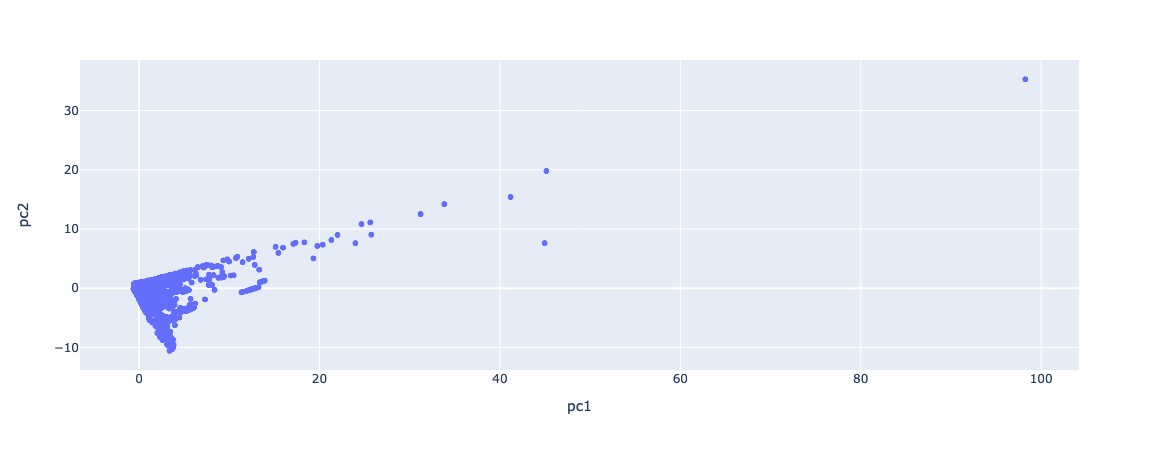

In [158]:
import plotly.express as px
df = data_pca
fig = px.scatter(df, x="pc1", y="pc2", hover_data=[df.index])
fig.show()

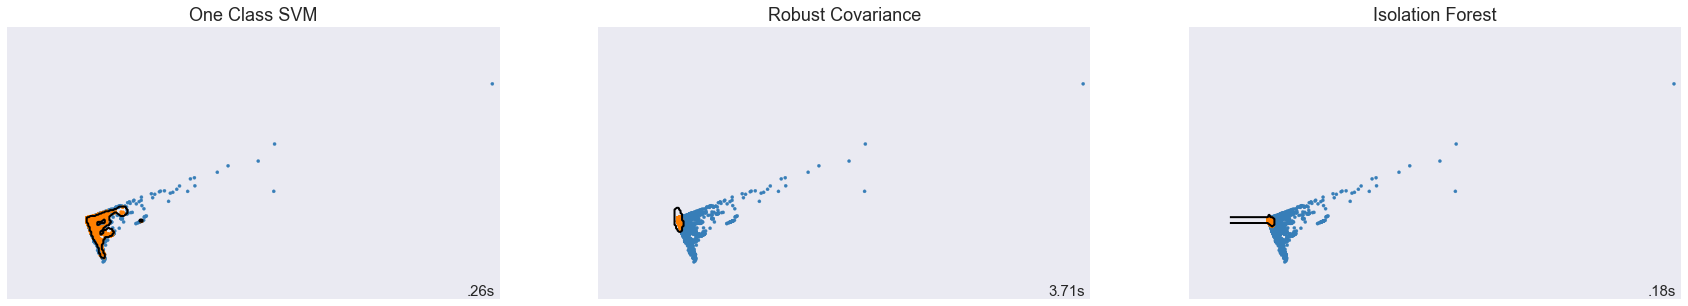

In [165]:
rcParams['figure.figsize'] = 30, 5
anomaly_algorithms = [('One Class SVM', ocsvm), 
                      ('Robust Covariance',rocov), 
                      ('Isolation Forest',isofor)]
plot_num = 1
xx, yy = np.meshgrid(np.linspace(-10, 100, 300),np.linspace(-20, 40, 200))
for name, algorithm in anomaly_algorithms:
    model = algorithm
    t0 = time.time()
    model.fit(X_pca)
    t1 = time.time()
    plt.subplot(1, len(anomaly_algorithms), plot_num)

    plt.title(name, size=18)

    # fit the data and tag outliers
    y_pred = algorithm.predict(X_pca)

    # plot the levels lines and the points
    Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

    colors = np.array(['#377eb8', '#ff7f00'])
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, color=colors[(y_pred + 1) // 2])

    plt.xlim(-20, 100)
    plt.ylim(-20, 50)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num+=1

plt.show()

# Bandingkan dengan kelas Fraud yang sudah tertangkap

In [166]:
src_fraud = fraud['source_num'].unique()

In [167]:
intersect = np.intersect1d(src_fraud, data_predict.index.to_numpy())
different = np.setdiff1d(src_fraud, data_predict.index.to_numpy())

In [168]:
len(intersect), len(different), len(src_fraud)

(9, 60, 69)

In [172]:
data_ready.reindex(different)

,duration,dest_num,org_dest_num,source_num_nunique,dest_num_nunique,total_duration,avg_interval
source_num,,,,,,,
212510621,3303.0,3.0,2.0,27.0,61.0,36557.0,53213.0
213924532,5697.0,3.0,2.0,2.0,4.0,5697.0,11527.0
215241000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215257481,148658.0,127.0,28.0,2.0,132.0,150246.0,3239.0
215762295,19567.0,17.0,14.0,9.0,89.0,49078.0,20567.0
215762343,10637.0,5.0,4.0,9.0,89.0,49078.0,840.0
215762346,10252.0,6.0,5.0,9.0,89.0,49078.0,796.0
215762916,8523.0,6.0,6.0,20.0,57.0,39426.0,889.0
215803357,3979.0,3.0,2.0,5.0,13.0,6861.0,30217.0


# Kesimpulan